# Isomap - Fashion MNIST

## Importaciones

In [42]:
import pandas as pd
import matplotlib
import os

import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import gdown
import numpy as np
import struct
from sklearn.preprocessing import MinMaxScaler
from sklearn.svm import SVC
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import (
    accuracy_score,
    precision_score,
    recall_score,
    f1_score,
    confusion_matrix,
    ConfusionMatrixDisplay,
)
from sklearn.manifold import Isomap

## Funciones de Carga de Datos

In [43]:
def download_data(file_id, name_file):
    url = f"https://drive.google.com/uc?id={file_id}"
    gdown.download(url, name_file, quiet=False)
    return name_file

def read_labels(file_path, n_samples=None):
    class_names = {
        0: "T-shirt/top",
        1: "Trouser",
        2: "Pullover",
        3: "Dress",
        4: "Coat",
        5: "Sandal",
        6: "Shirt",
        7: "Sneaker",
        8: "Bag",
        9: "Ankle boot",
    }
    
    with open(file_path, "rb") as f:
        magic, num_labels = struct.unpack(">II", f.read(8))
        if n_samples is None:
            n_samples = num_labels
        labels = np.frombuffer(f.read(n_samples), dtype=np.uint8)
    df = pd.DataFrame(labels, columns=["label"])
    df["class_name"] = df["label"].map(class_names)
    return df

def extrar_feature_images(file_path, n_samples=None, chunk_size=1000):
    """
    Extrae las imágenes del archivo binario en chunks para ahorrar memoria.
    
    Args:
        file_path: Ruta al archivo
        n_samples: Número de muestras a extraer (None para todas)
        chunk_size: Tamaño de los chunks para procesar
    """
    with open(file_path, "rb") as f:
        magic, num_images, rows, cols = struct.unpack(">IIII", f.read(16))
        if n_samples is None:
            n_samples = num_images
        else:
            n_samples = min(n_samples, num_images)
            
        print(f"Extrayendo {n_samples} imágenes de {num_images}")
        print("Dimensiones de cada imagen:", rows, "x", cols)
        
        # Pre-asignar array resultado con float32 para ahorrar memoria
        X = np.empty((n_samples, rows * cols), dtype=np.float32)
        
        bytes_per_img = rows * cols
        for i in range(0, n_samples, chunk_size):
            end_idx = min(i + chunk_size, n_samples)
            n_imgs_chunk = end_idx - i
            chunk_bytes = f.read(n_imgs_chunk * bytes_per_img)
            
            # Procesar chunk
            chunk_data = np.frombuffer(chunk_bytes, dtype=np.uint8)
            chunk_images = chunk_data.reshape(n_imgs_chunk, rows * cols)
            X[i:end_idx] = chunk_images
            
        print("Forma de la matriz final:", X.shape)
    return X

## Funciones de Visualización

In [44]:
def Show_Image(X, nro_imagen):
    if nro_imagen < 0 or nro_imagen >= X.shape[0]:
        raise IndexError(
            f"El índice {nro_imagen} está fuera de rango. Debe estar entre 0 y {X.shape[0]-1}"
        )

    img = X[nro_imagen].reshape(28, 28)
    plt.imshow(img, cmap="gray")
    plt.title(f"Imagen #{nro_imagen}")
    plt.axis("off")
    plt.show()


def visualizar_reduccion_2d(X_reduced, y, metodo_nombre, class_names_dict):
    plt.figure(figsize=(12, 10))

    for clase in np.unique(y):
        indices = y == clase
        plt.scatter(
            X_reduced[indices, 0],
            X_reduced[indices, 1],
            label=class_names_dict[clase],
            alpha=0.6,
            s=20,
        )

    plt.xlabel("Componente 1")
    plt.ylabel("Componente 2")
    plt.title(f"Visualización 2D - {metodo_nombre}")
    plt.legend(bbox_to_anchor=(1.05, 1), loc="upper left")
    plt.tight_layout()
    plt.show()

## Funciones de Preprocesamiento

In [45]:
def normalize_train(x, chunk_size=10000):
    """
    Normaliza los datos de entrenamiento usando MinMaxScaler, procesando en chunks.
    """
    n_samples = x.shape[0]
    n_features = x.shape[1]
    result = np.empty_like(x, dtype=np.float32)  # Usar float32 para reducir memoria
    scaler = MinMaxScaler()
    
    # Ajustar el scaler con una muestra de los datos
    sample_indices = np.random.choice(n_samples, min(chunk_size, n_samples), replace=False)
    scaler.fit(x[sample_indices])
    
    # Transformar por chunks
    for i in range(0, n_samples, chunk_size):
        end_idx = min(i + chunk_size, n_samples)
        result[i:end_idx] = scaler.transform(x[i:end_idx])
    
    return result, scaler

def normalize_test(x, scaler, chunk_size=10000):
    """
    Normaliza los datos de prueba usando el scaler ajustado, procesando en chunks.
    """
    n_samples = x.shape[0]
    result = np.empty_like(x, dtype=np.float32)  # Usar float32 para reducir memoria
    
    for i in range(0, n_samples, chunk_size):
        end_idx = min(i + chunk_size, n_samples)
        result[i:end_idx] = scaler.transform(x[i:end_idx])
    
    return result

def addBias(x, chunk_size=10000):
    """
    Agrega una columna de unos para el bias, procesando en chunks para ahorrar memoria.
    """
    n_samples = x.shape[0]
    n_features = x.shape[1]
    result = np.empty((n_samples, n_features + 1), dtype=np.float32)  # Usar float32
    
    for i in range(0, n_samples, chunk_size):
        end_idx = min(i + chunk_size, n_samples)
        result[i:end_idx, 0] = 1
        result[i:end_idx, 1:] = x[i:end_idx]
    
    return result

## Función de Isomap

In [46]:
def isomap_embedding(
    X,
    n_components=2,
    n_neighbors=5,
    eigen_solver="auto",
    n_jobs=-1,
):
    iso = Isomap(
        n_components=n_components,
        n_neighbors=n_neighbors,
        eigen_solver=eigen_solver,
        n_jobs=n_jobs,
    )

    X_embedded = iso.fit_transform(X)

    return iso, X_embedded

## Funciones de Evaluación

In [47]:
def generar_matriz_confusion(
    y_true, y_pred, modelo_nombre, class_names=None
):
    cm = confusion_matrix(y_true, y_pred)
    cm_normalized = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

    disp = ConfusionMatrixDisplay(confusion_matrix=cm_normalized, display_labels=class_names)
    fig, ax = plt.subplots(figsize=(10, 10))
    disp.plot(ax=ax, cmap="Blues", values_format=".2f")
    plt.title(f"Matriz de Confusión - {modelo_nombre}")
    plt.tight_layout()
    plt.show()

    return cm


def evaluar_modelos(
    X_train, y_train, X_test, y_test, mostrar_matrices=True, save_dir="resultados"
):
    modelos = {
        "SVM": SVC(kernel="rbf", class_weight="balanced", random_state=42),
        "Logistic Regression": LogisticRegression(
            max_iter=2000, solver="saga", class_weight="balanced", random_state=42
        ),
        "Random Forest": RandomForestClassifier(
            n_estimators=200, class_weight="balanced", random_state=42
        ),
        "KNN": KNeighborsClassifier(n_neighbors=5),
    }

    class_names = [
        "T-shirt",
        "Trouser",
        "Pullover",
        "Dress",
        "Coat",
        "Sandal",
        "Shirt",
        "Sneaker",
        "Bag",
        "Ankle boot",
    ]

    if mostrar_matrices:
        os.makedirs(save_dir, exist_ok=True)

    resultados = []

    for nombre, modelo in modelos.items():
        print(f"\nEntrenando {nombre}...")
        modelo.fit(X_train, y_train)
        y_pred = modelo.predict(X_test)

        resultados.append(
            {
                "Modelo": nombre,
                "Accuracy": accuracy_score(y_test, y_pred),
                "Precision": precision_score(
                    y_test, y_pred, average="weighted", zero_division=0
                ),
                "Recall": recall_score(
                    y_test, y_pred, average="weighted", zero_division=0
                ),
                "F1-Score": f1_score(
                    y_test, y_pred, average="weighted", zero_division=0
                ),
            }
        )

        if mostrar_matrices:
            generar_matriz_confusion(y_test, y_pred, nombre, class_names)

    return pd.DataFrame(resultados)

## Cargar Datos

In [48]:
# Descargando la data solo la primera vez
file_train_X = download_data("1enziBIpqiv_t95KQcifsclNH2BdR8lAd","train_X")
file_test_X = download_data("1Jeax6tnQ6Nmr2PTNXdQqzKnN0YqtrLe4","test_X")
file_train_Y = download_data("1MZtn2iA5cgiYT1i3O0ECuR01oD0kGHh7","train_Y")
file_test_Y = download_data("1K5pxwk2s3RDYsYuwv8RftJTXZ-RGR7K4","test_Y")

Downloading...
From: https://drive.google.com/uc?id=1enziBIpqiv_t95KQcifsclNH2BdR8lAd
To: e:\06. Sexto Ciclo\01. Machine Learning\07. Workspace\09S03. Proyecto 02\06C_Machine_06S01_Dimension_Reduction\notebooks\train_X
100%|██████████| 47.0M/47.0M [00:01<00:00, 27.0MB/s]

Downloading...
From: https://drive.google.com/uc?id=1Jeax6tnQ6Nmr2PTNXdQqzKnN0YqtrLe4
To: e:\06. Sexto Ciclo\01. Machine Learning\07. Workspace\09S03. Proyecto 02\06C_Machine_06S01_Dimension_Reduction\notebooks\test_X
  0%|          | 0.00/7.84M [00:00<?, ?B/s]Downloading...
From: https://drive.google.com/uc?id=1Jeax6tnQ6Nmr2PTNXdQqzKnN0YqtrLe4
To: e:\06. Sexto Ciclo\01. Machine Learning\07. Workspace\09S03. Proyecto 02\06C_Machine_06S01_Dimension_Reduction\notebooks\test_X
100%|██████████| 7.84M/7.84M [00:00<00:00, 17.7MB/s]

Downloading...
From: https://drive.google.com/uc?id=1MZtn2iA5cgiYT1i3O0ECuR01oD0kGHh7
To: e:\06. Sexto Ciclo\01. Machine Learning\07. Workspace\09S03. Proyecto 02\06C_Machine_06S01_Dimension_Red

## Preprocesamiento - Normalización

In [ ]:
n_samples = 10000  
n_test = 2000    

# Cargar datos de entrenamiento
print("Cargando datos de entrenamiento...")
train_X = extrar_feature_images(file_train_X, n_samples=n_samples)
train_Y = read_labels(file_train_Y, n_samples=n_samples)

# Cargar datos de prueba
print("\nCargando datos de prueba...")
test_X = extrar_feature_images(file_test_X, n_samples=n_test)
test_Y = read_labels(file_test_Y, n_samples=n_test)

# Normalizar
print("\nNormalizando datos...")
train_X_norm, scaler = normalize_train(train_X)
test_X_norm = normalize_test(test_X, scaler)

# Agregar bias
print("\nAgregando término de bias...")
train_X_norm = addBias(train_X_norm)
test_X_norm = addBias(test_X_norm)

print("\nFormas finales:")
print(f"X_train: {train_X_norm.shape}")
print(f"X_test: {test_X_norm.shape}")

Cargando datos de entrenamiento...
Extrayendo 10000 imágenes de 60000
Dimensiones de cada imagen: 28 x 28
Forma de la matriz final: (10000, 784)

Cargando datos de prueba...
Extrayendo 2000 imágenes de 10000
Dimensiones de cada imagen: 28 x 28
Forma de la matriz final: (2000, 784)

Normalizando datos...

Agregando término de bias...

Formas finales:
X_train: (10000, 785)
X_test: (2000, 785)


## Isomap 2D

In [50]:
class_names_dict = {
    0: "T-shirt/top",
    1: "Trouser",
    2: "Pullover",
    3: "Dress",
    4: "Coat",
    5: "Sandal",
    6: "Shirt",
    7: "Sneaker",
    8: "Bag",
    9: "Ankle boot",
}

# Reducir el tamaño de la muestra para visualización
n_viz = min(60000, len(train_X_norm))
viz_indices = np.random.choice(len(train_X_norm), n_viz, replace=False)
X_viz = train_X_norm[viz_indices]
y_viz = train_Y["label"].values[viz_indices]

print(f"Generando embedding Isomap 2D para {n_viz} muestras...")
iso_2d, X_isomap_2d = isomap_embedding(
    X_viz,
    n_components=2,
    n_neighbors=10,
    eigen_solver="auto",
    n_jobs=-1
)

print("Visualizando resultados...")
visualizar_reduccion_2d(
    X_isomap_2d,
    y_viz,
    "Isomap",
    class_names_dict,
)

Generando embedding Isomap 2D para 60000 muestras...


MemoryError: Unable to allocate 26.8 GiB for an array with shape (60000, 60000) and data type float64

## Implementacion de Isomap


In [ ]:
n_components_clf = 150  

print(f"Generando embedding Isomap con {n_components_clf} componentes...")
iso_clf, train_X_isomap = isomap_embedding(
    train_X_norm, 
    n_components=n_components_clf,
    n_neighbors=5,  
    eigen_solver="dense",  
    n_jobs=-1  
)
print("Embedding completado.")

Generando embedding Isomap con 150 componentes...
Embedding completado.
Embedding completado.


In [ ]:
print("Transformando datos test...")
test_X_isomap = iso_clf.transform(test_X_norm)
print("Transformación test completada.")

Transformando datos test...
Transformación test completada.


In [ ]:
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression

clasificadores = {
    'SVM': SVC(kernel='rbf', random_state=42),
    'KNN': KNeighborsClassifier(n_neighbors=5),
    'Random Forest': RandomForestClassifier(n_estimators=100, random_state=42),
    'Regresión Logística': LogisticRegression(max_iter=1000, random_state=42)
}

resultados = {}

y_train = train_Y['label'].values
y_test = test_Y['label'].values

for nombre, clf in clasificadores.items():
    print(f"\nEntrenando {nombre}...")
    
    clf.fit(train_X_isomap, y_train)
    
    y_pred = clf.predict(test_X_isomap)
    
    from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
    
    accuracy = accuracy_score(y_test, y_pred)
    precision = precision_score(y_test, y_pred, average='weighted')
    recall = recall_score(y_test, y_pred, average='weighted')
    f1 = f1_score(y_test, y_pred, average='weighted')
    
    resultados[nombre] = {
        'Accuracy': accuracy,
        'Precision': precision,
        'Recall': recall,
        'F1-Score': f1
    }
    
    print(f"{nombre} - Accuracy: {accuracy:.4f}, F1-Score: {f1:.4f}")

import pandas as pd

df_resultados = pd.DataFrame(resultados).transpose()
print("\nResultados detallados:")
print(df_resultados)


Entrenando y evaluando clasificadores...

Entrenando SVM...
SVM - Accuracy: 0.8130, F1-Score: 0.8147

Entrenando KNN...
KNN - Accuracy: 0.7905, F1-Score: 0.7911

Entrenando Random Forest...
Random Forest - Accuracy: 0.8000, F1-Score: 0.8012

Entrenando Regresión Logística...
Regresión Logística - Accuracy: 0.8100, F1-Score: 0.8117

Resultados detallados:
                     Accuracy  Precision  Recall  F1-Score
SVM                    0.8130   0.818175  0.8130  0.814697
KNN                    0.7905   0.794903  0.7905  0.791127
Random Forest          0.8000   0.803811  0.8000  0.801242
Regresión Logística    0.8100   0.814972  0.8100  0.811725


e:\06. Sexto Ciclo\01. Machine Learning\07. Workspace\09S03. Proyecto 02\06C_Machine_06S01_Dimension_Reduction\venv\Lib\site-packages\sklearn\linear_model\_logistic.py:473: ConvergenceWarning: lbfgs failed to converge after 1000 iteration(s) (status=1):
STOP: TOTAL NO. OF ITERATIONS REACHED LIMIT

Increase the number of iterations to improve the convergence (max_iter=1000).
You might also want to scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(



Generando visualización en 2D...


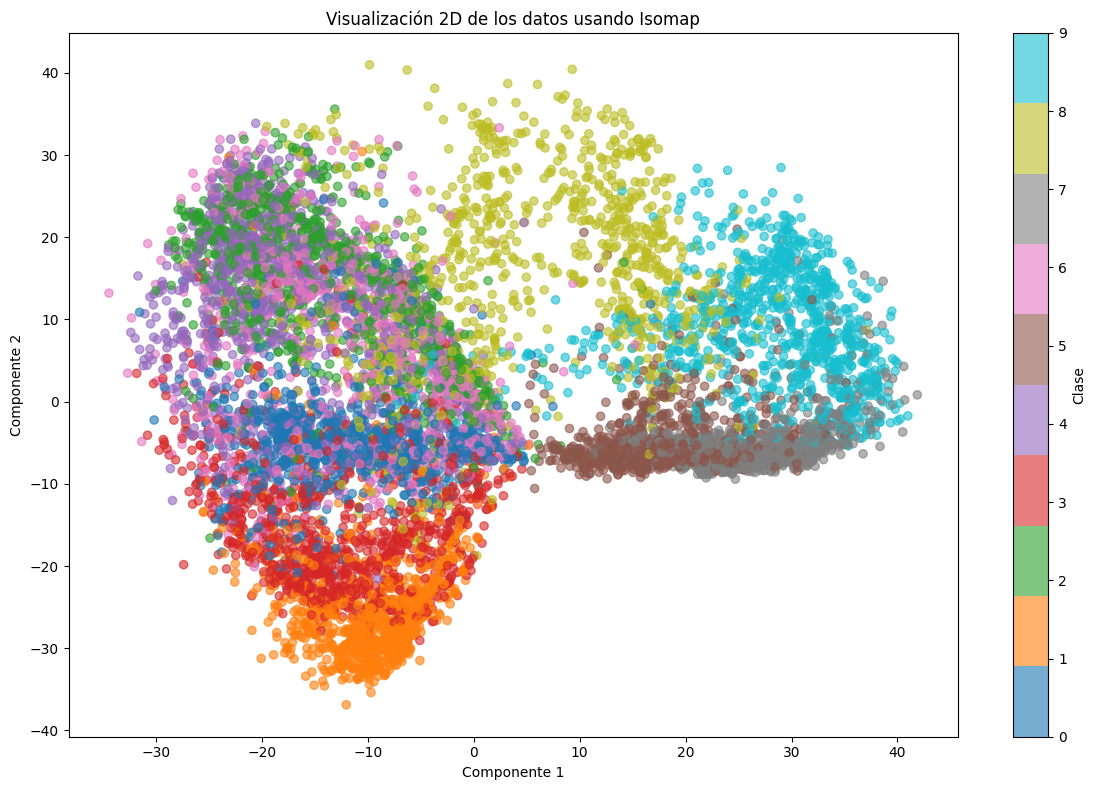


Guardando modelos y resultados...
Proceso completado exitosamente.


In [ ]:
print("\nGenerando visualización en 2D...")

n_components_viz = 2
iso_viz, train_X_isomap_2d = isomap_embedding(
    train_X_norm, 
    n_components=n_components_viz,
    n_neighbors=5,
    eigen_solver="dense",
    n_jobs=-1
)

import matplotlib.pyplot as plt

plt.figure(figsize=(12, 8))
scatter = plt.scatter(train_X_isomap_2d[:, 0], train_X_isomap_2d[:, 1], 
                     c=train_Y['label'].values, cmap='tab10', alpha=0.6)
plt.colorbar(scatter, label='Clase')
plt.title('Visualización 2D de los datos usando Isomap')
plt.xlabel('Componente 1')
plt.ylabel('Componente 2')
plt.tight_layout()
plt.show()

import joblib
import json
import os

os.makedirs('outputs/models', exist_ok=True)

joblib.dump(iso_clf, 'outputs/models/reducer_isomap_clf.joblib')

metadatos = {
    'n_components': n_components_clf,
    'n_neighbors': 5,
    'eigen_solver': 'dense',
    'resultados_clasificacion': resultados
}

with open('outputs/models/reducer_isomap_clf_meta.json', 'w') as f:
    json.dump(metadatos, f, indent=4)

print("Proceso completado exitosamente.")

**bold text** Transformar Datos de Test

In [ ]:
n_test_samples = 2000 
indices_test = np.random.choice(len(test_X_norm), n_test_samples, replace=False)
test_X_subset = test_X_norm[indices_test]
test_y_subset = test_Y["label"].values[indices_test]

batch_size = 200  
n_batches = n_test_samples // batch_size
test_X_isomap = np.zeros((n_test_samples, n_components_clf))

for i in range(n_batches):
    start_idx = i * batch_size
    end_idx = start_idx + batch_size
    batch_data = test_X_subset[start_idx:end_idx]
    test_X_isomap[start_idx:end_idx] = iso_clf.transform(batch_data)
    print(f"Lote {i+1}/{n_batches} completado")

Transformando 200 muestras de prueba en 4 lotes...
Lote 1/4 completado
Lote 2/4 completado
Lote 1/4 completado
Lote 2/4 completado
Lote 3/4 completado
Lote 4/4 completado
Lote 3/4 completado
Lote 4/4 completado


## Entrenamiento y Evaluación de Modelos


Entrenando SVM...


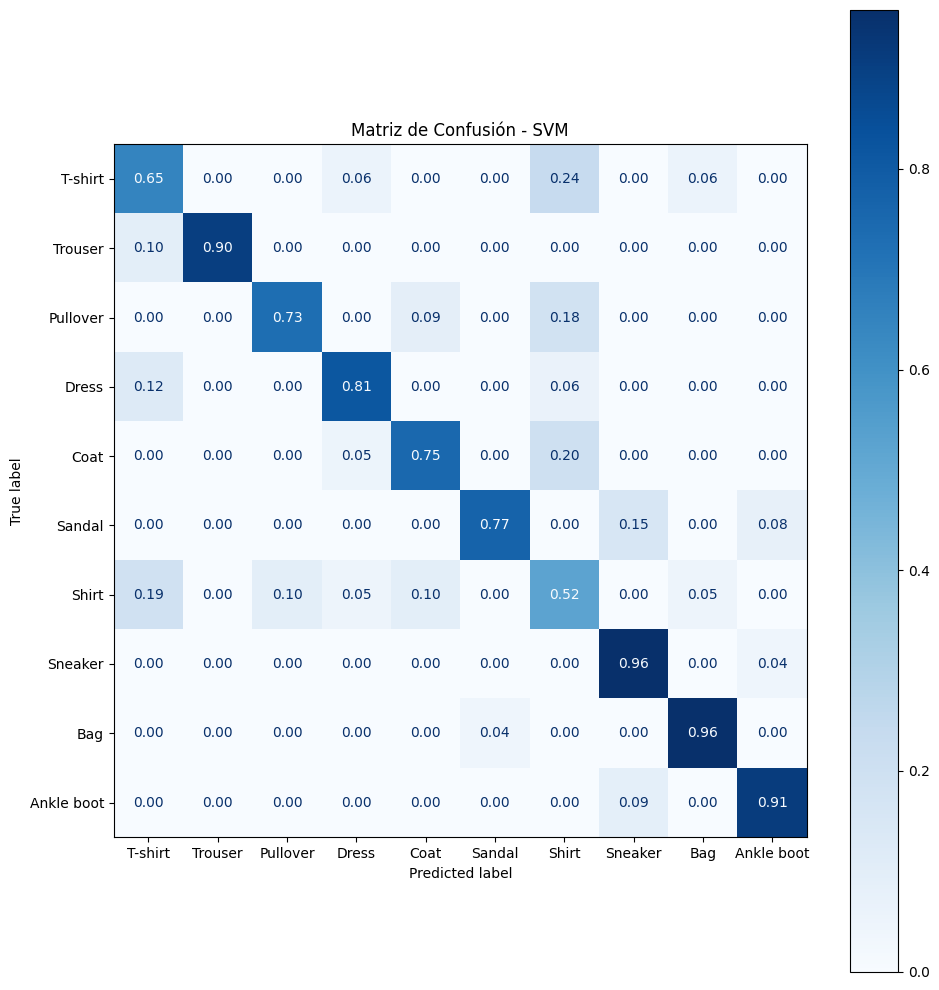


Entrenando Logistic Regression...


e:\06. Sexto Ciclo\01. Machine Learning\07. Workspace\09S03. Proyecto 02\06C_Machine_06S01_Dimension_Reduction\venv\Lib\site-packages\sklearn\linear_model\_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


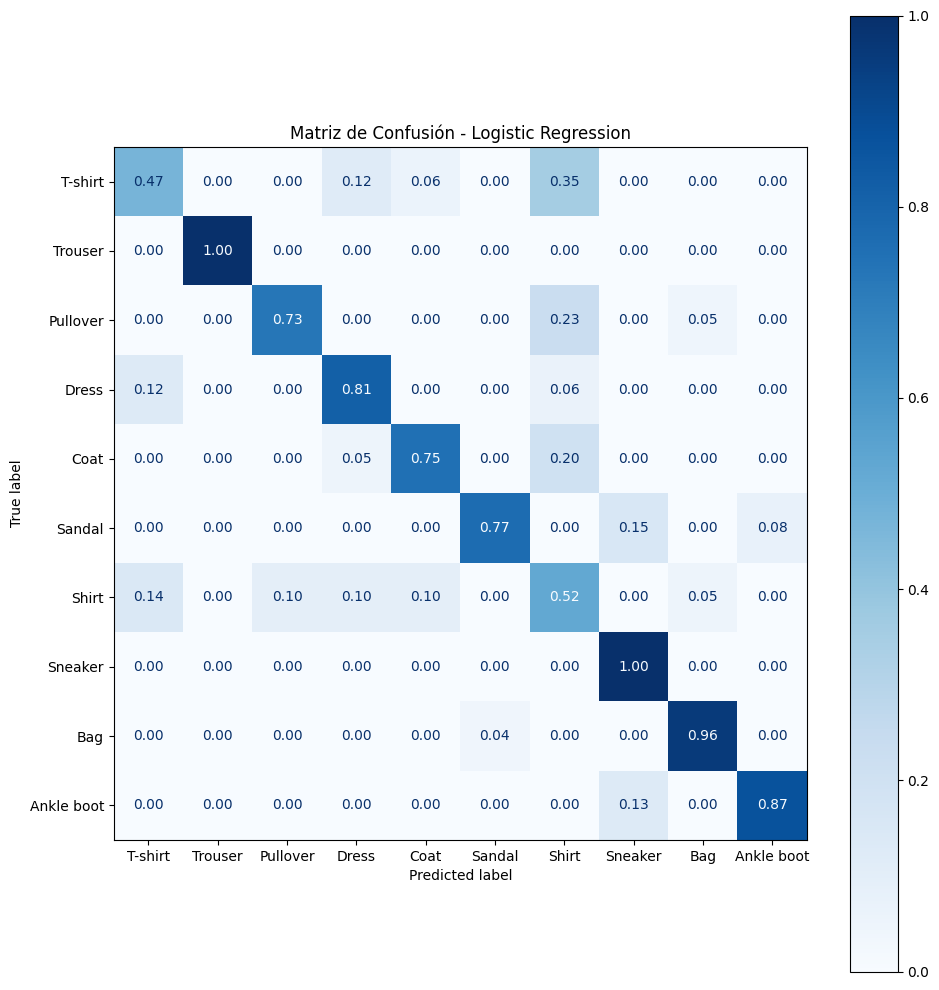


Entrenando Random Forest...


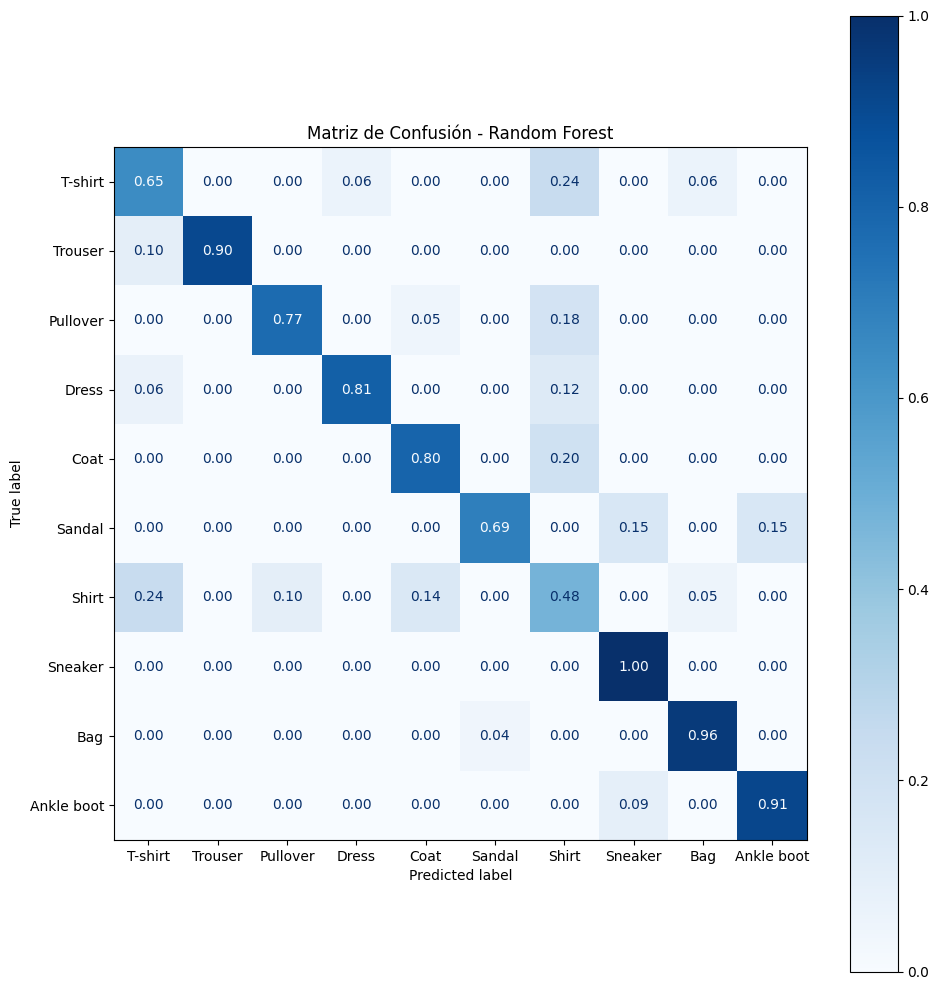


Entrenando KNN...


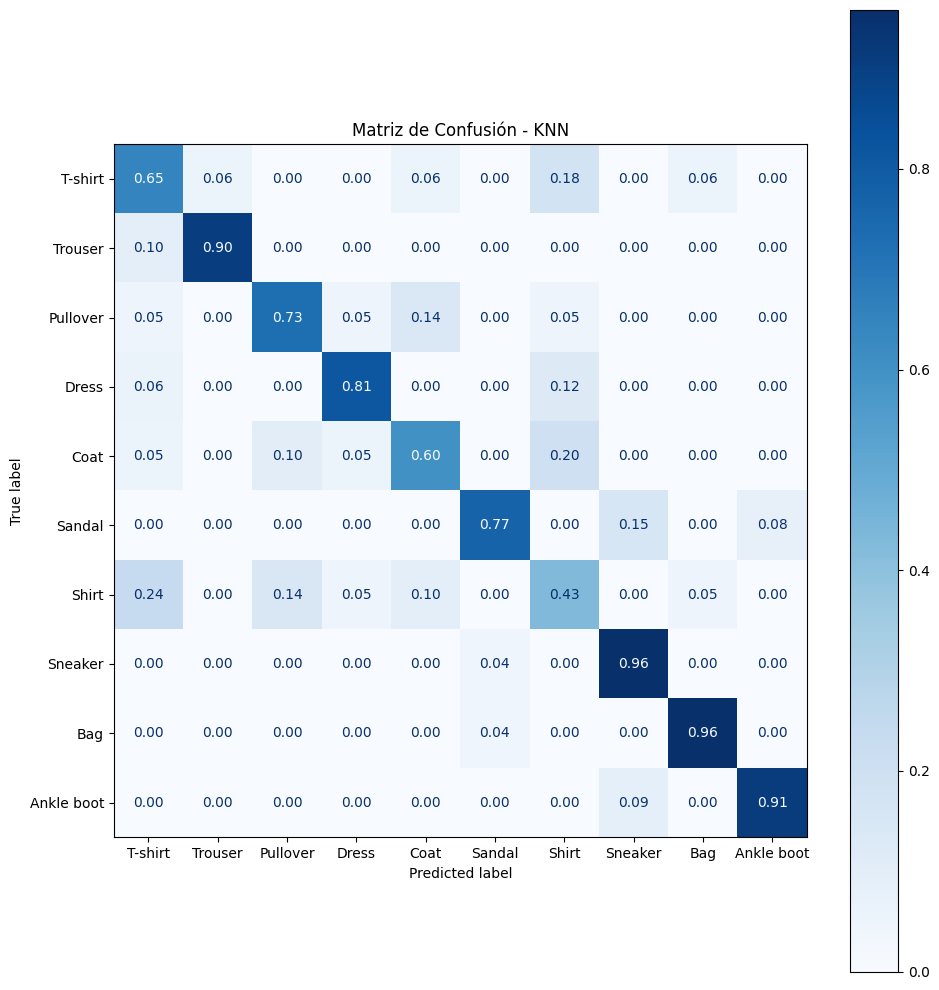

             Modelo  Accuracy  Precision  Recall  F1-Score
                SVM     0.805   0.815859   0.805  0.808036
Logistic Regression     0.800   0.812453   0.800  0.801673
      Random Forest     0.810   0.822530   0.810  0.813237
                KNN     0.780   0.781134   0.780  0.779048


In [ ]:
resultados_isomap = evaluar_modelos(
    train_X_isomap,
    y_train_subset,  
    test_X_isomap,
    test_y_subset,  
    mostrar_matrices=True,
    save_dir="resultados_isomap",
)

print(resultados_isomap.to_string(index=False))